## FKA122: H3 | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(path):
    data = pd.read_csv(path,delimiter=',',header=None)
    data = np.asarray(data)
    return data


def save_fig(fig, name, task):
    fig.savefig(f'figs/task_{task}/{name}.pdf', bbox_inches='tight')


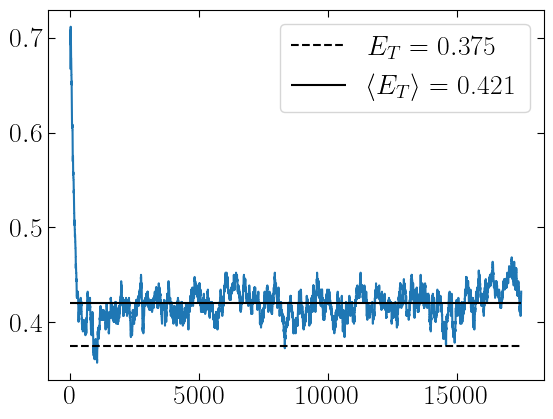

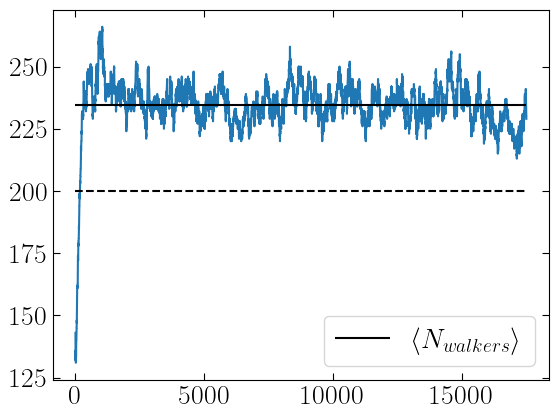

In [47]:
plt.figure()
ET = read_data('E_T_non_eq.csv')[:,0]
plt.plot(ET)
plt.hlines(3/8,0,len(ET),'k',label = f"$E_T={3/8:.3f}$", linestyle = 'dashed')
plt.hlines(np.mean(ET),0,len(ET),colors='k', label = f'$\\langle E_T\\rangle$ = {np.mean(ET):.3f}')
plt.legend()

plt.figure()
walk = read_data('E_T_non_eq.csv')[:,1]
plt.plot(walk)
plt.hlines(200,0,len(walk),'k', linestyle = 'dashed')
plt.hlines(np.mean(walk),0,len(walk),colors ='k', label = '$\\langle N_{walkers}\\rangle$')
plt.legend()